# Data Analysis of the London Fire Brigade

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from itertools import combinations
from branca.colormap import LinearColormap
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from time import time

In [3]:
# Load public data on incidents of the LFB
incidents = pd.read_feather('full-data')
n = incidents.shape[0]

In [5]:
# Load public socioeconomic data of London - already preprocessed
boroughsData=pd.read_csv('Data/boroughsData.csv')
boroughsData=boroughsData.drop(['Unnamed: 0','HLEF','HLE M','Resident Population'],axis=1)

geo_path = 'data/london_boroughs.json'

In [8]:
# Sets of variables we will consider
var_x_4 = ['Population', 'Homeless', 'Touristes', 'LE']
var_x_10 = ['Population', 'Homeless', 'Touristes', 'LE', 'Area', 'Logement', 'EducationScore', 'Density', 'PaidLessThanLW', 'Happiness']
var_x_12 = ['Population', 'Homeless', 'Touristes', 'LE', 'Area', 'Logement', 'EducationScore', 'Density', 'PaidLessThanLW', 'Happiness', 'Risque', 'Unemployment']
all_var_x=['Population','Area','Density','Happiness','Logement','LE','Unemployment','Homeless','EducationScore','PaidLessThanLW','Etrangers','Risque','Touristes']

In [127]:
# Westminster = False to exclude Westminster data
# Data processing
def create_data(pack,n_tot,Westminster=False):
    n_pack = pack.shape[0]
    q=n_tot/n_pack
    pack = pack.groupby(['IncGeo_BoroughCode','IncGeo_BoroughName','IncidentGroup']).size().to_frame('nb')
    pack = pack.reset_index()
    pack = pack.join(boroughsData.set_index('Code'), on='IncGeo_BoroughCode').dropna()
    FA_borough = pack[pack['IncidentGroup']=='False Alarm'][['IncGeo_BoroughCode','nb']]
    SS_borough = pack[pack['IncidentGroup']=='Special Service'][['IncGeo_BoroughCode','nb']]
    pack = pack[pack['IncidentGroup']=='Fire']
    pack = pack.join(SS_borough.set_index('IncGeo_BoroughCode'),on='IncGeo_BoroughCode',rsuffix='_ss')
    pack = pack.join(FA_borough.set_index('IncGeo_BoroughCode'),on='IncGeo_BoroughCode',rsuffix='_fa')
    pack = pack.rename(columns={"nb": "nb_fire"})
    pack['nb_incidents'] = pack['nb_fire']+pack['nb_fa']+pack['nb_ss']
    pack['nb_no_fa'] = pack['nb_incidents']-pack['nb_fa']
    pack['Pop3'] = pack['Population']**0.15
    pack['nb_incidents']*=q
    pack['nb_fire']*=q
    pack['nb_fa']*=q
    pack['nb_ss']*=q
    pack['nb_no_fa']*=q
    pack['log_incidents'] = np.log(pack['nb_incidents'])
    pack['log_Pop'] = np.log(pack['Population'])
    if(Westminster == False):
        pack = pack[pack['IncGeo_BoroughCode']!="E09000033"] # Pour éliminer Westminster
    pack = pack.reset_index()
    return pack

In [128]:
# Divide incidents in a training set and a test set
def divise(incidents, taille_verif=0.2, Westminster=False):
    n_tot = incidents.shape[0]
    n_verif = int(taille_verif*n_tot)
    indices = np.random.choice(n_tot, n_verif, replace=False)
    verif = incidents.iloc[indices]
    incidents = incidents.drop(indices).reset_index(drop=True)
    verif = create_data(verif,n_tot, Westminster)
    return incidents, verif

In [129]:
# Linear regression, with ElasticNet regularization if elastic=True with parameter alpha
def regression(train_data,test_data,var_x,var_y,affichage,elastic=False,alpha=0.5):
    x = train_data[var_x]
    y = train_data[var_y]
    y_verif = test_data[var_y]
    if(elastic):
        regr = linear_model.ElasticNet(alpha,l1_ratio=0.5)
    else:
        regr = linear_model.LinearRegression()
    regr.fit(x,y)
    a = regr.coef_
    b = regr.intercept_
    y_pred = np.dot(a,test_data[var_x].T)+b
    r2 = r2_score(y_verif,y_pred)
    e = mean_squared_error(y_verif,y_pred)
    if(affichage):
        print("y=ax+b avec : a=",a," b=",b)
        print("EQM = ",e, " --- R^2 = ",r2)
        affichage_courbes(test_data,var_x,var_y,y_verif,y_pred)
    return a,b,r2,e

In [130]:
# Plot either y = f(x) if x is one-dimensional, otherwise plot y_pred = f(y)
def affichage_courbes(data,var_x,var_y,y_verif,y_estimes):
    if(len(var_x)<2):
        plt.scatter(data[var_x[0]], y_verif,  color='black', label='Mesures')
        for i in range(len(y_verif)):
            plt.annotate(data['IncGeo_BoroughName'][i], (data[var_x[0]][i], y_verif[i]),fontsize=7)
        plt.plot(data[var_x[0]], y_estimes,  color='black', label='Estimation')
        plt.legend(loc='upper left')
        plt.xlabel(var_x[0])
        plt.ylabel(var_y)
    else :   
        plt.scatter(y_verif,y_estimes)
        for i in range(len(y_estimes)):
                plt.annotate(data['IncGeo_BoroughName'][i], (y_verif[i], y_estimes[i]),fontsize=7)
        plage = [min(min(y_verif),min(y_estimes)),max(max(y_verif),max(y_estimes))]
        plt.plot(plage,plage,linestyle='--',color='b')
        plt.axis('equal')
        plt.xlabel('Données réelles ('+var_y+')')
        plt.ylabel('Données prédites ('+var_y+')')
    plt.show()

In [131]:
# Classical implementation of a linear regression with cross validation on data aggregated per borough
def cross_validation_normal(incidents,var_x,var_y, n_tot,affichage=False,nb_tests=5,nb_packs=5,elastic=False,alpha=0.5, Westminster=False):
    data = create_data(incidents,n_tot, Westminster)
    reg_a = np.zeros([nb_tests*nb_packs,len(var_x)])
    reg_b = np.zeros([nb_tests*nb_packs])
    coef_r2 = np.zeros([nb_tests*nb_packs])
    eqm = np.zeros([nb_tests*nb_packs])
    n = data.shape[0]
    indices = np.arange(0,n)
    p = 1+n//nb_packs
    for i in range(nb_tests):
        np.random.shuffle(indices)
        packs = []
        for j in range(nb_packs-1):
            packs.append(data.iloc[indices[j*p:(j+1)*p]])
        packs.append(data.iloc[indices[p*(nb_packs-1):]])
        for j in range(nb_packs):
            test = packs[j].reset_index()
            train = pd.concat([packs[k] for k in range(nb_packs) if k!=j]).reset_index()
            h = i*nb_packs+j
            reg_a[h],reg_b[h],coef_r2[h],eqm[h] = regression(train,test,var_x,var_y,affichage,elastic,alpha)
    return reg_a,reg_b,coef_r2,eqm

In [132]:
# Natural implementation of a linear regression with cross validation and data split on all the incident data
def cross_validation_original(incidents,var_x,var_y,n_tot,affichage=False,nb_tests=5,nb_packs=5,elastic=False,alpha=0.5):
    reg_a = np.zeros([nb_tests*nb_packs,len(var_x)])
    reg_b = np.zeros([nb_tests*nb_packs])
    coef_r2 = np.zeros([nb_tests*nb_packs])
    eqm = np.zeros([nb_tests*nb_packs])
    n = incidents.shape[0]
    indices = np.arange(0,n)
    p = n//nb_packs
    for i in range(nb_tests):
        np.random.shuffle(indices)
        packs = []
        for j in range(nb_packs-1):
            packs.append(incidents.iloc[indices[j*p:(j+1)*p]])
        packs.append(incidents.iloc[indices[p*(nb_packs-1):]])
        for j in range(nb_packs):
            test = packs[j]
            train = pd.concat([packs[k] for k in range(nb_packs) if k!=j])
            test = create_data(test,n_tot)
            train = create_data(train,n_tot)
            h = i*nb_packs+j
            reg_a[h],reg_b[h],coef_r2[h],eqm[h] = regression(train,test,var_x,var_y,affichage,elastic,alpha)
    return reg_a,reg_b,coef_r2,eqm

In [133]:
# Implementation of a linear regression with cross validation on data aggregated per borough, sampling borough data with replacement
def cross_validation_bootstrap(incidents,var_x,var_y,n_tot,affichage=False,nb_tests=5,taille_tirage=2/3,elastic=False,alpha=0.5):
    reg_a = np.zeros([nb_tests,len(var_x)])
    reg_b = np.zeros([nb_tests])
    eqm = np.zeros([nb_tests])
    coef_r2 = np.zeros([nb_tests])
    n = incidents.shape[0]
    p = int(taille_tirage*n)
    for i in range(nb_tests):
        tirage = np.random.randint(0,n,p)
        train = incidents.iloc[tirage]
        train = train.reset_index()
        test = incidents.drop(tirage)
        restants = test.shape[0]
        utilises = n - restants
        if (affichage):
            print("Nombre d'enregistrements distincts utilisés pour l'entraînement : ",utilises," (",round(utilises/n,2),"%)")
            print("Taille échantillon d'entraînement : ",p)
        test = create_data(test,n_tot)
        train = create_data(train,n_tot)
        reg_a[i],reg_b[i],coef_r2[i],eqm[i] = regression(train,test,var_x,var_y,affichage,elastic,alpha)
    return reg_a,reg_b,coef_r2,eqm

In [134]:
def cross_validation(incidents,var_x,var_y,n_tot,nb_tests,nb_packs,taille_tirage,methode,elastic,alpha,Westminster=False):
    if (methode == 'Normal'):
        return cross_validation_normal(incidents,var_x,var_y,n_tot,False,nb_tests,nb_packs,elastic,alpha,Westminster)
    elif methode == 'Original' :
        return cross_validation_original(incidents,var_x,var_y,n_tot,False,nb_tests,nb_packs,elastic,alpha)
    else:
        return cross_validation_bootstrap(incidents,var_x,var_y,n_tot,False,nb_tests*nb_packs,taille_tirage,elastic,alpha)


In [143]:
# Putting everything together
def cross_verification(data,verif,methode,n_tot=n,var_x=var_x_4,var_y='nb_no_fa',ponderation=0,nb_tests=5,nb_packs=5,taille_tirage=2/3,elastic=False,alpha=0.5,Westminster=False):
    reg_a,reg_b,coef_r2,eqm = cross_validation(data,var_x,var_y,n_tot,nb_tests,nb_packs,taille_tirage,methode,elastic,alpha, Westminster)
    moy_a = np.mean(reg_a,axis=0)
    moy_b = np.mean(reg_b)
    var_a = np.var(reg_a,axis=0)
    var_b = np.var(reg_b)
    if(ponderation>0):
        weights = (np.maximum(coef_r2,0)/np.max(coef_r2))**ponderation
        moy_a_av = np.sum(np.multiply(reg_a.T,weights).T,axis=0)/np.sum(weights)
        moy_b_av = np.sum(weights*reg_b)/np.sum(weights)
    y_verif = verif[var_y]
    y_estimes = np.dot(moy_a,verif[var_x].T)+moy_b
    eqm_verif = mean_squared_error(y_verif,y_estimes)
    r2_verif = r2_score(y_verif,y_estimes)
    affichage_courbes(verif,var_x,var_y,y_verif,y_estimes)
    print("y=ax+b avec : a=",moy_a," b=",moy_b)
    print("EQM = ",eqm_verif," ---- R^2 = ",r2_verif)
    if(ponderation>0):
        y_estimes_av = np.dot(moy_a_av,verif[var_x].T)+moy_b_av
        eqm_av = mean_squared_error(y_verif,y_estimes_av)
        r2_av = r2_score(y_verif,y_estimes_av)
        print("Avec pondération :")
        print("y=ax+b avec : a=",moy_a_av," b=",moy_b_av)
        print("EQM = ",eqm_av," ---- R^2 = ",r2_av)
    verif['ecart'] = abs(verif[var_y]-y_estimes)/y_estimes
    return (moy_a,moy_b,r2_verif,var_a,var_b,verif[['Borough',var_y,'ecart']])


In [179]:
# Comparing the different cross validation implementations
def cross_verification_compare(data,verif,var_x,var_y,elastic=False,alpha=0.5,n_tot=n,taille_verif=0.2,nb_tests=5,nb_packs=5,taille_tirage=2/3):
    y_verif = verif[var_y]
    Methodes = ['Normal','Original','Bootstrap']
    times=[]
    for met in Methodes :
        st=time()
        print("Méthode : ",met)
        a,b,r2,va,vb,ecarts=cross_verification(data,verif,met,n_tot,var_x,var_y,0,nb_tests,nb_packs,taille_tirage,elastic,alpha)
        times.append(time()-st)
        print("\n")
    return times

In [171]:
# Do linear regression with cross validation on all possible combinations of variables given an ensemble of variables
def allCombVarX(data,verif,var_y,nb_var_x,n_tot=n,var_x_possibles=all_var_x,elastic=False,alpha=0.5):
    y_verif = verif[var_y]
    combinaisons = combinations(var_x_possibles, nb_var_x)
    L=[]
    bestR2=0
    bestVarX=[]
    times=[]
    for c in combinaisons:
        st=time()
        var_x = np.array(c)
        reg_a,reg_b,coef_r2,err = cross_validation_normal(incidents,var_x,var_y,n_tot,False,5,5,elastic,alpha)
        a = np.mean(reg_a,axis=0)
        b = np.mean(reg_b)
        #print("Variables x : ",var_x)
        #print("y=ax+b avec : a=",a," b=",b)
        y_estimes = np.dot(a,verif[var_x].T)+b
        eqm = mean_squared_error(y_verif,y_estimes)
        r2 = r2_score(y_verif,y_estimes)
        #print("EQM = ",eqm," ---- R^2 = ",r2)
        L.append([var_x,r2,eqm,a,b])
        if(r2>bestR2):
            bestR2=r2
            bestVarX=var_x
        times.append(time()-st)
    sorted(L,key=lambda x:x[1])
    return L,bestR2,bestVarX,times

In [166]:
# Incrementally increase the number of variables and compare the best regression found for a given number of variables for different numbers
def surApprentissage(data,verif,var_y,n_tot,var_x_possibles=all_var_x,elastic=False,alpha=0.5):
    R=[]
    bestR2 = []
    bestVarX = []
    times = []
    p=len(var_x_possibles)
    for k in range(1,p+1):
        L,r2,var_x,t=allCombVarX(data,verif,var_y,k,n_tot,var_x_possibles,elastic,alpha)
        R.append(L)
        bestR2.append(r2)
        bestVarX.append(var_x)
        times.append(np.mean(t))
    r2Max=[np.max([x[1] for x in R[k]]) for k in range(p)]
    r2Moy=[np.mean([x[1] for x in R[k]]) for k in range(p)]
    r2Min=[np.min([x[1] for x in R[k]]) for k in range(p)]
    plt.plot(range(1,p+1),r2Max,label='Meilleur r2')
    plt.plot(range(1,p+1),r2Moy,label='r2 moyen')
    plt.plot(range(1,p+1),r2Min,label='r2 minimal')
    plt.legend(loc='best')
    plt.show()
    return R,bestR2,bestVarX,times

In [139]:
# Provide a map of the boroughs with different colors for different values of var_y
def createMap(data,var_y):
    m = folium.Map(location=[51.5,-0.1], zoom_start=10)
    map_dict = data.set_index('Borough')[var_y].to_dict()
    color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))
    color_scale.caption = var_y
    m.add_child(color_scale)
    def get_color(feature):
        value = map_dict.get(feature['properties']['name'])
        if value is None:
            return '#8c8c8c' # gris si absence de donnée
        else:
            return color_scale(value)
    folium.GeoJson(
        data = geo_path,
        style_function = lambda feature: {
            'fillColor': get_color(feature),
            'fillOpacity': 0.6,
            'color' : 'black',
            'weight' : 1}).add_to(m)
    incidents_no_fa = incidents[incidents['IncidentGroup']!='False Alarm']
    toplot = incidents_no_fa[['Latitude', 'Longitude']].as_matrix().tolist()
    #toplot = random.sample(toplot, 2000)
    #plugins.HeatMap(toplot, radius=10).add_to(m)
    return m

In [9]:
# Process data
boroughs = create_data(incidents,n)

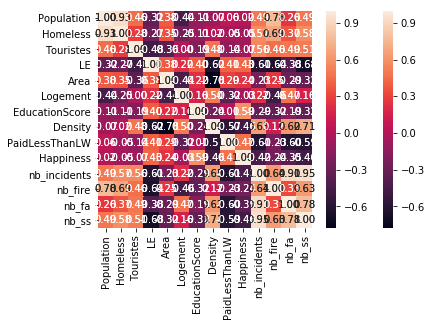

In [12]:
# Correlation between the variables
sns.heatmap(boroughs[var_x_10+['nb_incidents','nb_fire','nb_fa','nb_ss']].corr(), annot=True, fmt=".2f")
plt.show()

In [141]:
# Divide data
data,verif = divise(incidents)
dataW,verifW = divise(incidents,Westminster=True)

Méthode :  Normal


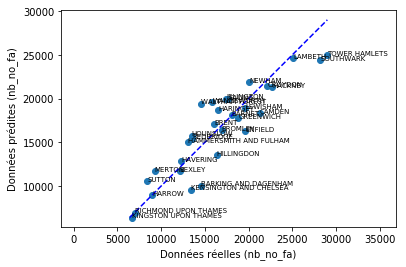

y=ax+b avec : a= [-4.71483838e-02  2.43046619e+02  1.53917303e+00 -8.37475792e+02]  b= 54715.95954664583
EQM =  5781957.716529703  ---- R^2 =  0.8103816031529798


Méthode :  Original


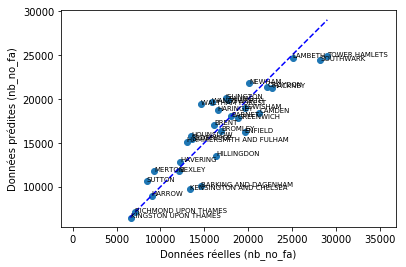

y=ax+b avec : a= [-4.91873555e-02  2.46799216e+02  1.53468703e+00 -8.36336311e+02]  b= 54840.426746833145
EQM =  5771032.959920311  ---- R^2 =  0.8107398788332557


Méthode :  Bootstrap


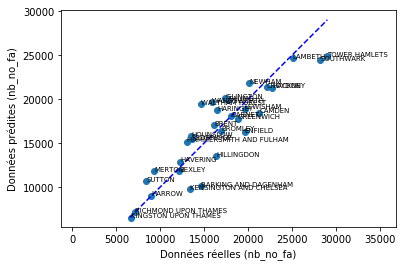

y=ax+b avec : a= [-4.95183749e-02  2.47299729e+02  1.54392374e+00 -8.35300185e+02]  b= 54799.67850336016
EQM =  5770923.453101187  ---- R^2 =  0.8107434700922209




[0.6400241851806641, 94.02406787872314, 70.58568286895752]

In [180]:
# Linear regression with 4 variables
cross_verification_compare(data,verif,var_x=['Population','Homeless','Touristes','LE'],var_y='nb_no_fa')

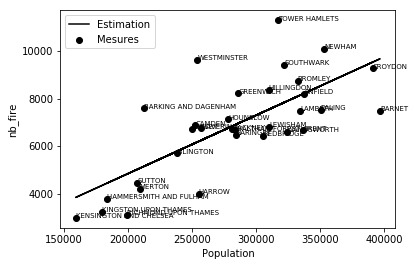

y=ax+b avec : a= [0.02451903]  b= -65.17779321621406
EQM =  1968880.7958472632  ---- R^2 =  0.5372756997034502


In [145]:
# Linear regression with 1 variable
regr1=cross_verification(dataW,verifW,var_x=['Population'],var_y='nb_fire',methode='Normal',Westminster='True')

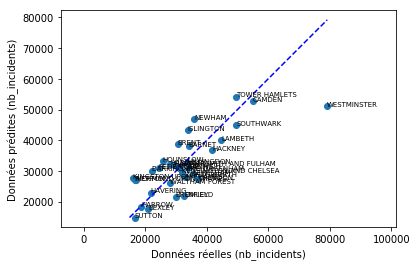

y=ax+b avec : a= [-822.64569937    6.46270054]  b= 41827.00483453441
EQM =  65364637.24161002  ---- R^2 =  0.6042120124376128


In [151]:
# Linear regression with 2 variables
regr2=cross_verification(dataW,verifW,var_x=['PaidLessThanLW','Touristes'],var_y='nb_incidents',methode='Normal',Westminster=True)

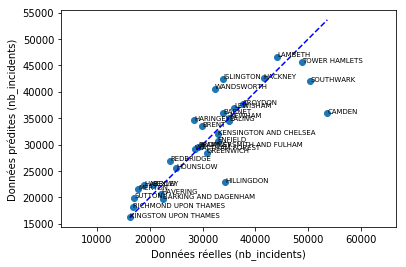

y=ax+b avec : a= [  1.58543904 257.08322133]  b= -8633.150811678835
EQM =  25868084.160298735  ---- R^2 =  0.7264992447401429


In [152]:
# Linear regression with 2 other variables
regr3=cross_verification(data,verif,var_x=['Density','Homeless'],var_y='nb_incidents',methode='Normal')

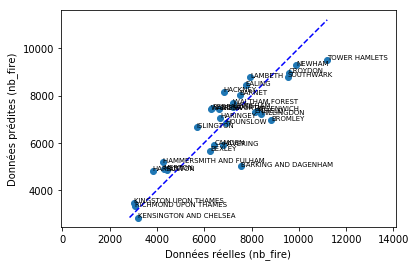

y=ax+b avec : a= [ 2.06894702e-02 -2.55952626e+02]  b= 17257.285072921717
EQM =  927986.1555438094  ---- R^2 =  0.7767192193416997


In [154]:
# Linear regression with 2 other variables
regr4=cross_verification(data,verif,var_x=['Population','LE'],var_y='nb_fire',methode='Normal')

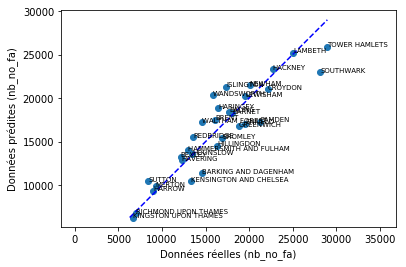

y=ax+b avec : a= [ 4.16774554e-02 -3.59724482e+02  6.71033337e-01  4.08836140e+01
 -1.08821115e+02 -6.78216765e+03]  b= 27317.23757476582
EQM =  4921744.754175462  ---- R^2 =  0.8385921523934775


In [155]:
# Linear regression with 6 variables
regr5=cross_verification(data,verif,var_x=['Population','LE','Density','Homeless','EducationScore','Etrangers'],var_y='nb_no_fa',methode='Normal')

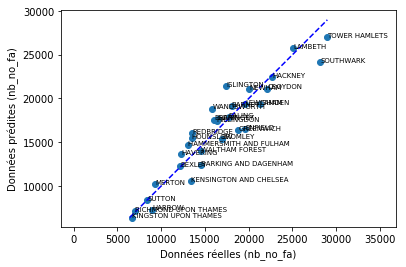

y=ax+b avec : a= [ 4.39089098e-02 -3.13588222e+02  5.54683920e-01  2.06915291e+01
 -2.13628595e+02 -2.45450730e+03  1.90927198e+00  1.91609604e+01
  3.19057808e+03 -2.30374178e+02]  b= 11986.311452545733
EQM =  3423600.225555816  ---- R^2 =  0.8877235673379114


In [160]:
# Linear regression with 10 variables
regr6=cross_verification(data,verif,var_x=['Population','LE','Density','Homeless','EducationScore','Etrangers','Risque','Area','Happiness','PaidLessThanLW'],var_y='nb_no_fa',methode='Normal')

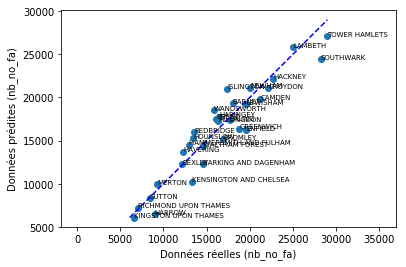

y=ax+b avec : a= [ 4.01919408e-02  1.19488265e+01  3.92577866e-01  3.80622188e+03
  1.76013122e-03 -4.04446607e+02  8.19905108e+01  2.75938925e+01
 -2.24857101e+02 -2.52197828e+02 -5.95373761e+03  3.24546936e+00
  4.58096786e-01]  b= 15082.111716848183
EQM =  3405536.7434659787  ---- R^2 =  0.8883159564011447


In [165]:
# Linear regression with all 13 variables
regr7=cross_verification(data,verif,var_x=all_var_x,var_y='nb_no_fa',methode='Normal')

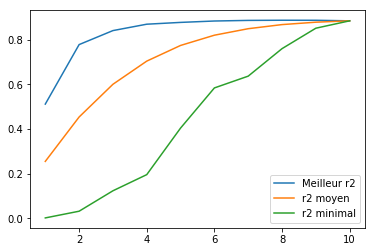

In [173]:
# Is increasing the number of variables improving the determination coefficient of the regression ?
S=surApprentissage(data,verif,'nb_no_fa',n,var_x_10)

/Users/marcos/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


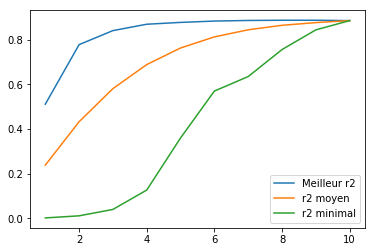

In [181]:
# When we had some regularization, does increasing the number of variables improving the determination coefficient of the regression ?
F = surApprentissage(data,verif,'nb_no_fa',n,var_x_10,elastic=True,alpha=1.0)

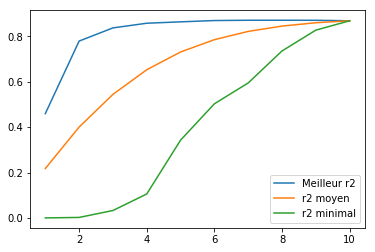

In [175]:
# When we had some regularization (alpha=30), does increasing the number of variables improving the determination coefficient of the regression ?
E=surApprentissage(data,verif,'nb_no_fa',n,var_x_10,elastic=True,alpha=30)

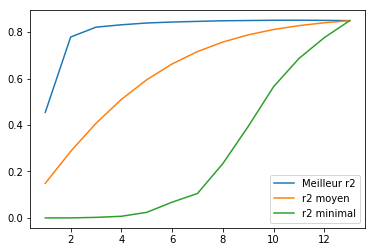

In [186]:
# When we had some regularization (alpha=100), does increasing the number of variables improving the determination coefficient of the regression ?
G=surApprentissage(data,verif,'nb_no_fa',n,var_x_possibles=all_var_x,elastic=True,alpha=100)

In [103]:
# Visualization of the boroughs with the higher number of fires
createMap(boroughs,'nb_no_fa')

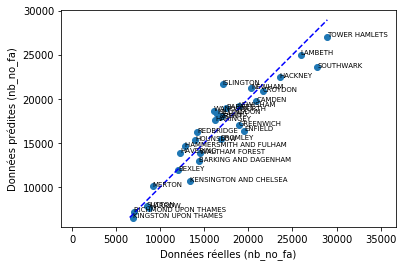

Sans pondération :
y=ax+b avec : a= [ 5.02060942e-02 -2.77484012e+02  2.81207298e+01  5.64422145e-01
 -1.93166978e+02 -2.19636363e+02]  b= 31548.1224975888
EQM =  3326923.411002068  ---- R^2 =  0.8908052591137063


In [106]:
# Model chosen
ecarts = cross_verification(data,verif,'Normal',var_x=['Population', 'LE', 'Area', 'Density', 'EducationScore', 'PaidLessThanLW'],var_y='nb_no_fa')[-1]

In [107]:
# Visualization of the boroughs that are predicted best by the model
createMap(ecarts,'ecart')